In [1]:
!pip install lifelines
!pip install scikit-survival
!pip install shap

     |████████████████████████████████| 419kB 2.9MB/s 
     |████████████████████████████████| 1.8MB 2.9MB/s 
     |████████████████████████████████| 153kB 22.6MB/s 
     |████████████████████████████████| 6.7MB 17.2MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.11-cp36-cp36m-linux_x86_64.whl size=2366757 sha256=63a40118469f81f08ec99cc0c69f40600c534c5c40ed751de4bc162895abd0bf
  Stored in directory: /root/.cache/pip/wheels/bf/2b/7d/8b998b558e8bd884960eb75344a1872ca0a1287d66a7834df0
Successfully built scikit-survival
  Found existing installation: osqp 0.6.1
    Uninstalling osqp-0.6.1:
      Successfully uninstalled osqp-0.6.1
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
     |████████████████████████████████| 266kB 2.6MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383188 sha256=891960ac8006134228bef88f9357edb6b206af77a038108536c9b5

In [2]:
from google.colab import drive
drive.mount('/mnt/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /mnt/drive


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, 
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from lifelines import CoxPHFitter
from sksurv.linear_model import CoxnetSurvivalAnalysis

sns.set_style("ticks")

## Challenge description


### Goal



The challenge proposed by Owkin is a supervised survival prediction problem: predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data. To each patient corresponds one CT scan, and one binary segmentation mask. The segmentation mask is a binary volume of the same size as the CT scan, except that it is composed of zeroes everywhere there is no tumour, and 1 otherwise. This segmentation mask was built based on annotations from radiologists, who delineated by hand the tumor(s).


### Data



__Inputs__

For each patient, there is four inputs:

  1. Images (one scan and one mask per patient): Crops of both the scan and the mask, centered around the tumor region. Those crops are of fixed 92^3 mm^3 size.
  2. Radiomics features (an ensemble of 53 quantitative features per patient, extracted from the scan).
  3. Clinical data

__Outputs__

Outputs must be positive floats which represent the predicted survival time in days. The file `train/output.csv` simply contains two columns, indexed by patient id: one column represents the observed time to event, while the other represents the censorship (1=event observed is death, 0=event observed is the last time patient was seen alive, the patient then escaped the study).

## Dive into the challenge



### Exploration, visualisation and features engineering

In [ ]:
project_path = Path("/mnt/drive/My Drive/Colab Notebooks/owkin-challenge")
model_path = project_path / "model"
data_path = project_path / "data"
train_dir, test_dir = data_path / "x_train", data_path / "x_test"

In [ ]:
def load_data(dataset_path, target=True, images=False):
  """
  """
  if not isinstance(data_path, Path):
    dataset_path = Path(dataset_path)

  radiomics_file = dataset_path / "features" / "radiomics.csv"
  columns = ["PatientID"] + list(pd.read_csv(radiomics_file, skiprows=1).columns[1:])
  radiomics = pd.read_csv(radiomics_file, skiprows=3, names=columns, index_col='PatientID')

  clinical_file = dataset_path / "features" / "clinical_data.csv"
  clinical = pd.read_csv(clinical_file, index_col='PatientID') 
  clinical.loc[:, 'Histology'] = clinical.Histology.str.lower()
  clinical.loc[clinical.Histology == 'nsclc nos (not otherwise specified)', 'Histology'] = 'nos'

  if target:
    target_file = dataset_path / "y_train.csv"
    target = pd.read_csv(target_file, index_col='PatientID') 

    return radiomics, clinical, target
  else:
    return radiomics, clinical

radiomics, clinical, target = load_data(train_dir, target=True)

#### radiomics features

In [266]:
print('n = {}\n'
      'd = {}'.format(*radiomics.shape))
radiomics.head()

n = 300
d = 53


,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,1.592466,241.0,-310.858031,288.311105,-266.0,-1006.0,1247.0,446.407319,-0.281714,320.385361,0.037008,102646.779451,1056.843506,546253.499762,-5334.563631,555.818455,54.336816,0.821101,3.845383,5.036775,0.005920,9.270194,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.249416,0.037768,61.035662,6.007130,0.926391,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,3.371013,262.0,-134.429809,191.395154,-15.0,-945.0,1207.0,268.966000,-1.216062,232.962090,0.080061,54271.335557,1219.689108,331155.230396,-6857.579704,295.032309,16.868781,0.891184,2.984034,2.570017,0.025532,7.551168,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.340024,0.110575,67.826804,5.255594,0.855154,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,7.585494,115.0,-54.136093,94.132136,2.0,-785.0,900.0,141.852795,-2.153344,131.116356,0.160905,17191.498865,972.465798,54523.086867,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,4.281865,274.0,-118.705522,149.072998,-37.0,-850.0,1124.0,224.397694,-1.437836,190.429315,0.074476,36263.324022,968.117567,166735.779994,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,8.999616,203.0,-67.201946,143.210231,14.0,-1023.0,1226.0,222.972850,-2.438490,212.604774,0.104419,45200.790098,1594.558416,658805.553990,-10509.915485,248.

In [267]:
radiomics[radiomics.isna().any(axis=1)]

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


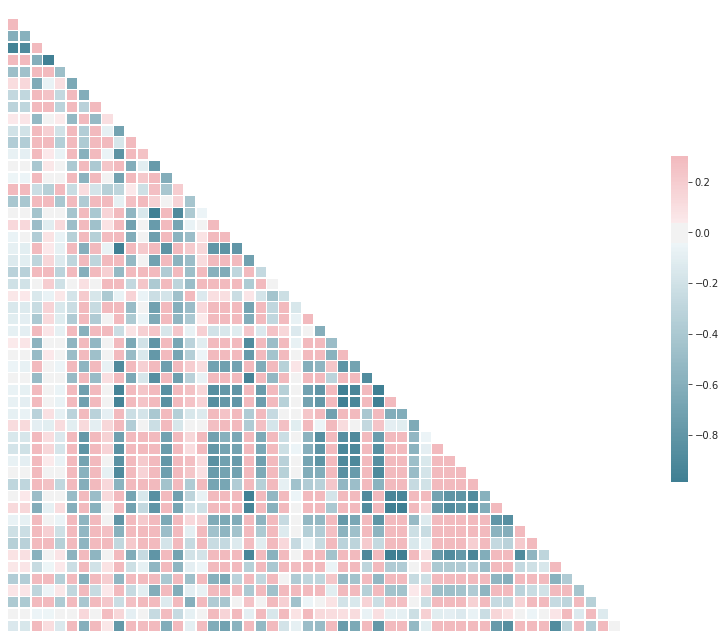

In [ ]:
def plot_diag_matrix_corr(df, figsize=(14, 12), show_labels=True):
  corr = df.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=np.bool))

  f, ax = plt.subplots(figsize=figsize)
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, xticklabels=show_labels,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=show_labels)

plot_diag_matrix_corr(radiomics, show_labels=False)

By looking at the matrix correlation, we see that many features are higly correlated beetwen each over. This colinearity may entails conditionnement problems for our matrix $X^{\top}X$ when apply regression models.

##### Compute VIF

We going to use the variance inflation factor (VIF) to diagnostic the multicollinearity in this dataset, which is computed for each explanatory variable.

If we consider the following linear model :

$$Y = \beta_0 + \beta_1 X_1 + ... + \beta_d X_d + \varepsilon$$

We know that the standard error of the estimate of $\beta_j$ is the square root of the $j+1$ diagonal element of $s^2(X^\top X)^{-1}$, where $s$ is the root mean squared error (RMSE). The square of this standard error, 
the estimated variance of the estimate of $\beta_j$, can be expressed as:

$$\hat{\text{var}}(\hat{\beta}_j) = \frac{s^2}{(n-1)\hat{\text{var}}(X_j)}\cdot \frac{1}{1-R^2_j}$$.

Where $R^2_j$ is the multiple $R^2$ for the regression of $X_j$ on the other covariates (a regression that does not involve the response variable $Y$). The terme $\frac{1}{1-R^2_j}$ is the VIF. It reflects all other factors that influence the uncertainty in the coefficient estimates. The VIF equals 1 when the vector $X_j$ is orthogonal to each column of the design matrix for the regression of $X_j$ on the other covariates. By contrast, the VIF is greater than 1 when the vector $X_j$ is not orthogonal to all columns of the design matrix for the regression of $X_j$ on the other covariates.

So we put the VIF threshold at the level of 10.0, which is a commonly used value, meaning if the VIF is above 10.0 we should consider there is effect of multicollinearity on your fitted model.

In [ ]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median',
                 index=None, verbose=True):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        self.index = index
        self.verbose = verbose
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        X_reduce = ReduceVIF.calculate_vif(X, self.thresh, verbose=self.verbose)
        return X_reduce if self.index is None else X_reduce.set_index(self.index)

    @staticmethod
    def calculate_vif(X, thresh=5.0, verbose=True):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                if verbose:
                  print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [6]:
transformer = ReduceVIF(thresh=10.0, index='PatientID')
radiomics_reduced = transformer.fit_transform(radiomics.reset_index())
radiomics_reduced.head()

ReduceVIF fit
ReduceVIF transform


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping original_firstorder_Maximum with vif=inf
Dropping original_shape_Sphericity with vif=10326979.9380088
Dropping original_glcm_Id with vif=1956977.5073346721
Dropping original_glcm_Idmn with vif=763291.6137276839
Dropping original_glcm_SumEntropy with vif=68539.1042663607
Dropping original_glcm_Idn with vif=54964.749457041755
Dropping original_firstorder_Entropy with vif=44577.95252302547
Dropping original_glrlm_RunPercentage with vif=37858.1325375695
Dropping original_glcm_SumAverage with vif=26673.95180884589
Dropping original_glrlm_HighGrayLevelRunEmphasis with vif=20326.658407915664
Dropping original_glrlm_ShortRunEmphasis with vif=13194.442111131892
Dropping original_shape_Compactness1 with vif=10170.658839457352
Dropping original_firstorder_Minimum with vif=8327.323791118157
Dropping original_glcm_DifferenceEntropy with vif=5375.936255518537
Dropping original_glcm_Imc2 with vif=3903.695658135155
Dropping original_firstorder_MeanAbsoluteDeviation with vif=3829.734358717632


,original_shape_Compactness2,original_shape_SurfaceVolumeRatio,original_firstorder_Energy,original_firstorder_Kurtosis,original_firstorder_Median,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis
PatientID,,,,,,,,,,,,,
202.0,0.274892,0.275228,3.942944e+09,1.592466,-266.0,-0.281714,546253.499762,-5334.563631,54.336816,0.005920,555.378594,0.003384,0.004444
371.0,0.188210,0.240727,3.122890e+09,3.371013,-15.0,-1.216062,331155.230396,-6857.579704,16.868781,0.025532,1766.619373,0.002069,0.003633
246.0,0.265740,0.200766,1.059535e+09,7.585494,2.0,-2.153344,54523.086867,-1618.363118,7.040623,0.066569,3462.816344,0.001635,0.004869
240.0,0.255406,0.323878,6.583324e+08,4.281865,-37.0,-1.437836,166735.779994,-3968.921514,13.656782,0.015048,683.869792,0.002680,0.003901
284.0,0.199424,0.327241,8.072532e+08,8.999616,14.0,-2.438490,658805.553990,-10509.915485,20.121147,0.029317,962.094760,0.004704,0.023273


In [8]:
print(f'We keep {radiomics_reduced.shape[1]} features from our {radiomics.shape[1]} because of too strong multicollinearity.')

We keep 13 features from our 53 because of too strong multicollinearity.


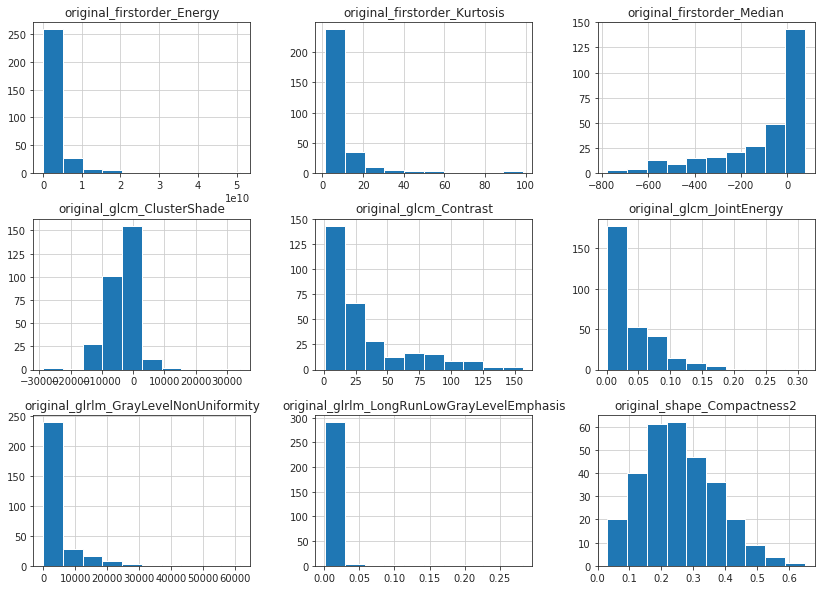

In [107]:
_ = radiomics_reduced.hist(figsize=(14, 10))

#### Clinical data

In [ ]:
print('n = {}\n'
      'd = {}'.format(*clinical.shape))
clinical.head()

n = 300
d = 6


,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


In [ ]:
nb_rows_with_nan = clinical[clinical.isna().any(axis=1)].shape[0]
print(f'Number of rows containing nan values: {nb_rows_with_nan}')

Number of rows containing nan values: 30


In [ ]:
for column in clinical.columns:
  print(f'{column} missing values: {clinical[column][clinical[column].isna()].shape[0]}')

Histology missing values: 20
Mstage missing values: 0
Nstage missing values: 0
SourceDataset missing values: 0
Tstage missing values: 0
age missing values: 16


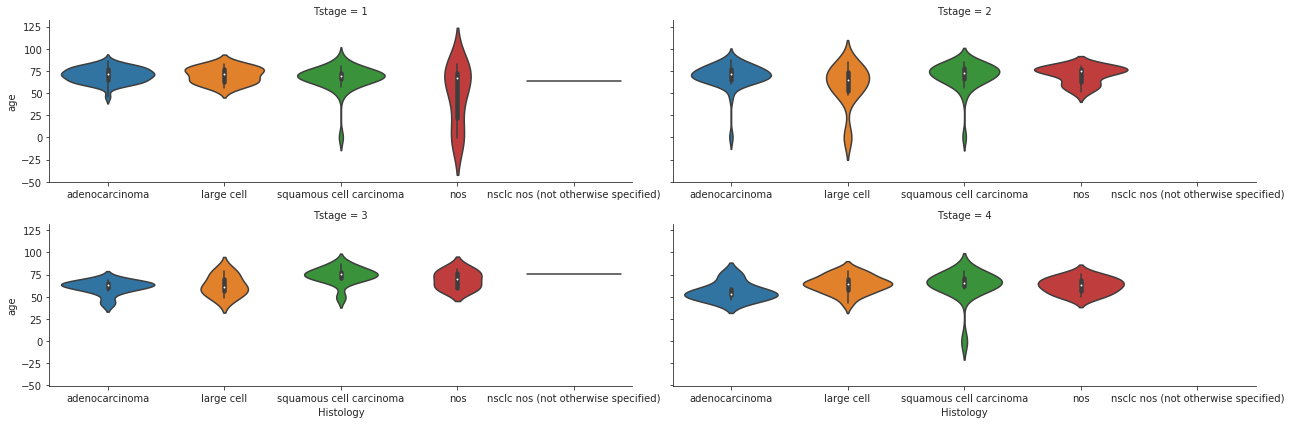

In [ ]:
chart = sns.catplot(x="Histology", y="age", kind="violin", col="Tstage", sharex=False,
                    col_wrap=2, data=clinical, aspect=3, height=3)

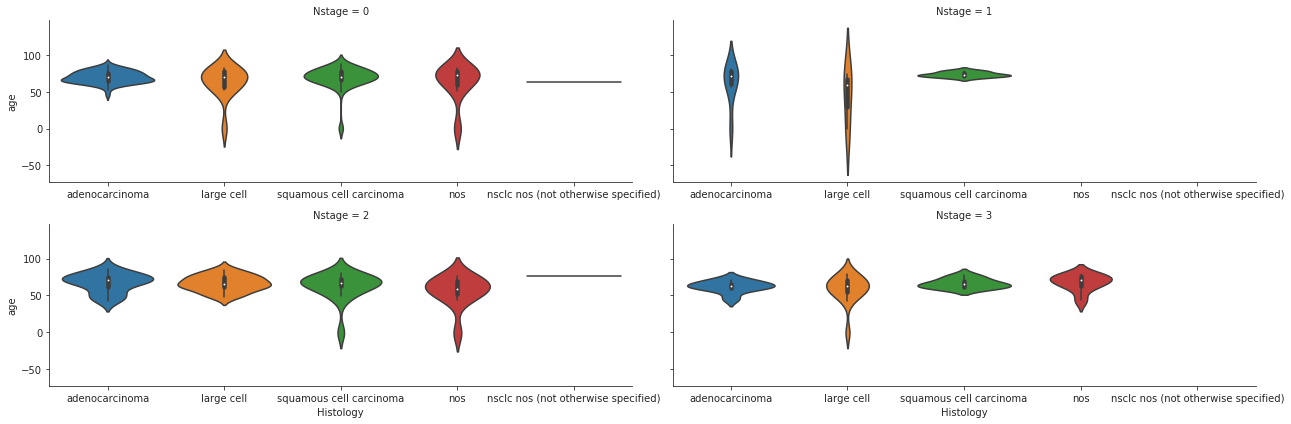

In [ ]:
chart = sns.catplot(x="Histology", y="age", kind="violin", col="Nstage", sharex=False,
                    col_wrap=2, data=clinical, aspect=3, height=3)

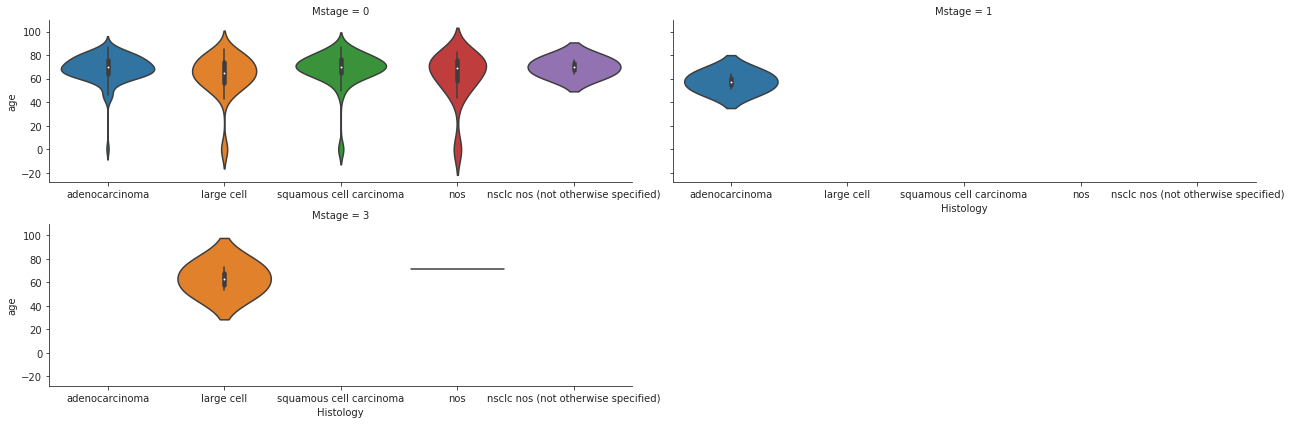

In [ ]:
chart = sns.catplot(x="Histology", y="age", kind="violin", col="Mstage", sharex=False,
                    col_wrap=2, data=clinical, aspect=3, height=3)

There is a significant amoung of missing values in the clinical dataset. One way, not the better one, is to drop all of the rows that contains a missing values. By doing that, we will loose a lot of potential information in our data.

An another method is to try to fill the missing values by some logical information : 
- Fill with statistics based on the distribution of each feature:
  - continuous features : fill missing value with mean of observations with same information
  - categorical features : Apply majority vote on observations with same informations
- We can train a model to predict  each feature of the dataset and fill the missing value by adding prediction of those regression models

##### Fill age column

We are going to train a non linear model SVR model to predict all missing values in the age column.

In [ ]:
def train_model_gridsearch(model, X, y, cv, parameters, output_path=None):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                      random_state=42)

  grid_search = GridSearchCV(model, parameters, cv=cv)
  grid_search.fit(X_train, y_train)
  grid_search.score(X_test, y_test)

  print(f"Generalization score for polynomial kernel: train:"
        f"{grid_search.score(X_train, y_train)}, test: {grid_search.score(X_test, y_test)}")
  print('Best params: ', grid_search.best_params_)

  # Save the model
  if output_path is not None:
    dump(grid_search, output_path)
  
  return grid_search

In [8]:
# data
cat_cols = list(clinical.columns[:-1])
age_col = [clinical.columns[-1]]
data = clinical.dropna()

features_processing_reg_age = ColumnTransformer([
 ("encode_categorical_columns", OneHotEncoder(sparse=False), cat_cols),
 ("rescale_age_column", StandardScaler(), age_col),
 ])

data_processed = features_processing_reg_age.fit_transform(data)
X, y = data_processed[:, :-1], data_processed[:, -1]

print(f'Train: {X.shape}\n'
      f'Test: {X.shape}')

Train: (270, 17)
Test: (270, 17)


In [ ]:
date = str(datetime.now()).replace(' ', '_')
Cs = list(np.logspace(-3, 3, 5))
gammas = 10. ** np.arange(1, 2)
degrees = np.r_[2, 3]
parameters = {'kernel': ['poly'], 'C': Cs,
              'gamma': gammas, 'degree': degrees}

date = str(datetime.now()).replace(' ', '_')
svr_age = train_model_gridsearch(model=SVR(), X=X, y=y,
                                  parameters=parameters, cv=3,
                                  output_path=model_path / f'svr_age_{date}.joblib')

Generalization score for polynomial kernel: train:0.22463977357569642, test: 0.23826071373763535
Best params:  {'C': 0.001, 'degree': 2, 'gamma': 10.0, 'kernel': 'poly'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


As expected, performance are not great but it will be suffisant to handle missing values.

In [ ]:
svr_age = load(model_path / 'svr_age_2020-02-11_19:31:37.568277.joblib')

In [ ]:
def age_fillna(row, svr_age, pipeline):
  scaler = pipeline.named_transformers_.rescale_age_column
  if np.isnan(row.age) and not row[:-1].isna().any():
    X = pipeline.transform(pd.DataFrame(row).T)
    row.age = scaler.inverse_transform(svr_age.predict(X[:, :-1]).reshape(-1, 1))[0][0]
    return row
  else:
    return row

clinical = clinical.apply(lambda row: age_fillna(row, svr_age, features_processing_reg_age), axis=1)

##### Fill Histology column

In [11]:
# data
cat_cols = list(clinical.columns[1:-1])
age_col = [clinical.columns[-1]]
hist_col = [clinical.columns[0]]
data = clinical.dropna()

features_processing_reg_hist = ColumnTransformer([
 ("encode_histology_column", OrdinalEncoder(), hist_col),                                                 
 ("encode_categorical_columns", OneHotEncoder(sparse=False), cat_cols),
 ("rescale_age_column", StandardScaler(), age_col)
 ])

data_processed = features_processing_reg_hist.fit_transform(data)
X, y = data_processed[:, 1:], data_processed[:, 0]

print(f'Train: {X.shape}\n'
      f'Test: {X.shape}')

Train: (280, 14)
Test: (280, 14)


In [ ]:
# We take the same parameters as the precedent training
parameters = {'kernel': ['poly', 'rbf', 'linear'], 'C': Cs,
              'gamma': gammas, 'degree': degrees}
date = str(datetime.now()).replace(' ', '_')

svc_hist = train_model_gridsearch(model=SVC(decision_function_shape='ovo'),
                                  X=X, y=y, parameters=parameters, cv=3,
                                  output_path=model_path / f'svc_hist_{date}.joblib')

Generalization score for polynomial kernel: train:0.6008403361344538, test: 0.4523809523809524
Best params:  {'C': 1.0, 'degree': 2, 'gamma': 10.0, 'kernel': 'linear'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
svc_hist = load(model_path / 'svc_hist_2020-02-11_19:52:36.445055.joblib')

In [ ]:
def hist_fillna(row, svc_hist, pipeline):
  encoder = pipeline.named_transformers_.encode_histology_column
  if row.Histology is np.NaN and not row[1:].isna().any():
    # add a value to avoid nan in pipeline
    row.Histology = 'adenocarcinoma'
    X = pipeline.transform(pd.DataFrame(row).T)
    row.Histology = encoder.inverse_transform(svc_hist.predict(X[:, 1:]).reshape(-1, 1))[0][0]
    return row
  else:
    return row

In [ ]:
clinical = clinical.apply(lambda row: hist_fillna(row, svc_hist,
                                                  features_processing_reg_hist), axis=1)

In [15]:
for column in clinical.columns:
  print(f'{column} missing values: {clinical[column][clinical[column].isna()].shape[0]}')

Histology missing values: 6
Mstage missing values: 0
Nstage missing values: 0
SourceDataset missing values: 0
Tstage missing values: 0
age missing values: 6


In [16]:
print(f'Number of obervations: {clinical.shape[0]}')
clinical.dropna(inplace=True)
print(f'Number of obervations after removing missing values: {clinical.shape[0]}')

Number of obervations: 300
Number of obervations after removing missing values: 294


#### Prepare the training data

In [133]:
data = clinical.join([radiomics_reduced, target], how='left')
data.shape

(294, 21)

In [134]:
data.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness2,original_shape_SurfaceVolumeRatio,original_firstorder_Energy,original_firstorder_Kurtosis,original_firstorder_Median,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202,adenocarcinoma,0.0,0.0,l2,2.0,66.0000,0.274892,0.275228,3.942944e+09,1.592466,-266.0,-0.281714,546253.499762,-5334.563631,54.336816,0.005920,555.378594,0.003384,0.004444,1378,0
371,large cell,0.0,2.0,l1,4.0,64.5722,0.188210,0.240727,3.122890e+09,3.371013,-15.0,-1.216062,331155.230396,-6857.579704,16.868781,0.025532,1766.619373,0.002069,0.003633,379,1
246,squamous cell carcinoma,0.0,3.0,l1,2.0,66.0452,0.265740,0.200766,1.059535e+09,7.585494,2.0,-2.153344,54523.086867,-1618.363118,7.040623,0.066569,3462.816344,0.001635,0.004869,573,1
240,nos,0.0,2.0,l1,3.0,59.3566,0.255406,0.323878,6.583324e+08,4.281865,-37.0,-1.437836,166735.779994,-3968.921514,13.656782,0.015048,683.869792,0.002680,0.003901,959,0
284,squamous cell carcinoma,0.0,3.0,l1,4.0,71.0554,0.199424,0.327241,8.072532e+08,8.999616,14.0,-2.438490,658805.553990,-10509.915485,20.121147,0.029317,962.094760,0.004704,0.023273,2119,0


In [135]:
# data
binary_cat_col = ['SourceDataset', 'Mstage', 'Nstage', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data.loc[:, 'age':].columns[:-2])

processing_data = ColumnTransformer([
 ("encode_binary_categorical_columns", OrdinalEncoder(categories='auto'), binary_cat_col),             
 ("encode_categorical_columns", OneHotEncoder(sparse=False, categories='auto'), cat_cols),
 ("rescale_continue_columns", StandardScaler(), quant_cols),
 ])

X = pd.DataFrame(processing_data.fit_transform(data.iloc[:, :-2]), index=data.index)
X['SurvivalTime'], X['Event'] = data['SurvivalTime'], data['Event']

X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,,,,
202,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.293491,0.184211,-0.344782,0.228773,-0.538674,-0.781994,0.752173,0.667254,-0.348309,0.729004,-0.745305,-0.473301,-0.160420,-0.221691,1378,0
371,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,-0.444614,-0.575949,-0.552043,0.068836,-0.407620,0.516385,0.150175,0.021530,-0.647175,-0.436433,-0.283258,-0.309281,-0.360357,-0.253849,379,1
246,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,-0.288707,0.103954,-0.792104,-0.333582,-0.097071,0.604323,-0.453713,-0.808919,0.380932,-0.742136,0.683529,-0.079591,-0.426473,-0.204814,573,1
240,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,-0.996650,0.013334,-0.052520,-0.411829,-0.340503,0.402583,0.007286,-0.472057,-0.080325,-0.536341,-0.530241,-0.455901,-0.267589,-0.243214,959,0
284,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,0.241589,-0.477605,-0.032319,-0.382785,0.007130,0.666397,-0.637432,1.005135,-1.363883,-0.335268,-0.194101,-0.418225,0.040251,0.525069,2119,0


In [136]:
transformer_X = ReduceVIF(thresh=6.0, index='PatientID')
X = transformer_X.fit_transform(X.reset_index())
X.head()

ReduceVIF fit
ReduceVIF transform
Dropping 4 with vif=7.782340821470436
Dropping 20 with vif=6.585178092278869


,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,,
202.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.293491,0.184211,-0.344782,0.228773,-0.538674,-0.781994,0.752173,0.667254,-0.348309,0.729004,-0.745305,-0.473301,-0.221691,1378.0,0.0
371.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,-0.444614,-0.575949,-0.552043,0.068836,-0.407620,0.516385,0.150175,0.021530,-0.647175,-0.436433,-0.283258,-0.309281,-0.253849,379.0,1.0
246.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,-0.288707,0.103954,-0.792104,-0.333582,-0.097071,0.604323,-0.453713,-0.808919,0.380932,-0.742136,0.683529,-0.079591,-0.204814,573.0,1.0
240.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,-0.996650,0.013334,-0.052520,-0.411829,-0.340503,0.402583,0.007286,-0.472057,-0.080325,-0.536341,-0.530241,-0.455901,-0.243214,959.0,0.0
284.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.241589,-0.477605,-0.032319,-0.382785,0.007130,0.666397,-0.637432,1.005135,-1.363883,-0.335268,-0.194101,-0.418225,0.525069,2119.0,0.0


In [ ]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

### Features extraction with CNN

### Modelisation

#### Cox’s proportional hazard model

In [21]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

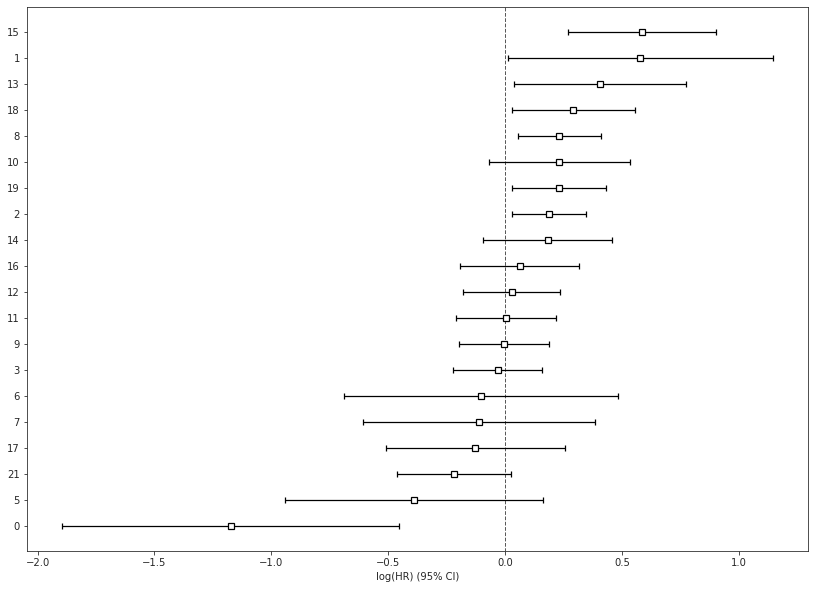

In [22]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [23]:
cph.score_

0.7274942377346065

In [66]:
from lifelines.utils import k_fold_cross_validation
from lifelines import CoxPHFitter

cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.7033315705975675, 0.6510248112189859, 0.6626379400945875, 0.7077087794432548]
0.681175775338599
0.02473667087165996


#### Better variable selection with features testing

In [24]:
data_not_reduced = clinical.join([radiomics, target], how='left')
data_not_reduced.shape

(294, 61)

In [25]:
data_not_reduced.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,adenocarcinoma,0.0,0.0,l2,2.0,66.0000,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,1.592466,241.0,-310.858031,288.311105,-266.0,-1006.0,1247.0,446.407319,-0.281714,320.385361,0.037008,102646.779451,1056.843506,546253.499762,-5334.563631,555.818455,54.336816,0.821101,3.845383,5.036775,0.005920,9.270194,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.249416,0.037768,61.035662,6.007130,0.926391,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761,1378,0
371,large cell,0.0,2.0,l1,4.0,64.5722,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,3.371013,262.0,-134.429809,191.395154,-15.0,-945.0,1207.0,268.966000,-1.216062,232.962090,0.080061,54271.335557,1219.689108,331155.230396,-6857.579704,295.032309,16.868781,0.891184,2.984034,2.570017,0.025532,7.551168,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.340024,0.110575,67.826804,5.255594,0.855154,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589,379,1
246,squamous cell carcinoma,0.0,3.0,l1,2.0,66.0452,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,7.585494,115.0,-54.136093,94.132136,2.0,-785.0,900.0,141.852795,-2.153344,131.116356,0.160905,17191.498865,972.465798,54523.086867,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080,573,1
240,nos,0.0,2.0,l1,3.0,59.3566,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,4.281865,274.0,-118.705522,149.072998,-37.0,-850.0,1124.0,224.397694,-1.437836,190.429315,0.074476,36263.324022,968.117567,166735.779994,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046,959,0
284,squam

In [137]:
# data
binary_cat_col = ['SourceDataset', 'Mstage', 'Nstage', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data_not_reduced.loc[:, 'age':].columns[:-2])

processing_data_forward = ColumnTransformer([
 ("encode_binary_categorical_columns", OrdinalEncoder(categories='auto'), binary_cat_col),             
 ("encode_categorical_columns", OneHotEncoder(sparse=False, categories='auto'), cat_cols),
 ("rescale_continue_columns", StandardScaler(), quant_cols),
 ])

X_not_reduced = pd.DataFrame(processing_data_forward.fit_transform(data_not_reduced.iloc[:, :-2]), index=data_not_reduced.index)
X_not_reduced['SurvivalTime'], X_not_reduced['Event'] = data_not_reduced['SurvivalTime'], data_not_reduced['Event']

X_not_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.293491,0.292416,0.184211,-0.434880,-0.410895,0.324500,-0.444108,-0.344782,-0.442463,0.228773,1.009108,-0.538674,-0.404519,-0.908328,1.432751,-0.781994,-0.807931,-0.183012,1.056621,0.752173,1.332420,-0.862985,1.425562,-0.204733,0.667254,-0.348309,1.455322,0.729004,0.205681,1.036616,0.902711,-0.745305,1.090713,-0.927604,-0.915097,0.759920,0.194099,-0.733123,-0.847730,-0.777966,-0.731626,-0.260705,1.045158,0.845890,-0.681237,-0.473301,-0.237848,0.864993,-0.174032,-0.274025,-0.160420,0.028410,-0.221691,-0.624654,1378,0
371,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,-0.444614,-0.482119,-0.575949,0.328405,0.232026,-0.440120,0.003069,-0.552043,-0.159880,0.068836,0.251775,-0.407620,-0.352152,0.181810,0.280078,0.516385,-0.212687,-0.275184,-0.095478,0.150175,0.271129,-0.310600,0.086414,0.226073,0.021530,-0.647175,0.139864,-0.436433,0.896632,-0.027011,-0.325511,-0.283258,0.117646,0.107629,0.095192,-0.393249,0.692459,0.424177,0.259284,0.321631,0.096032,0.275137,0.246165,0.085978,-0.212022,-0.309281,0.030167,-0.032454,-0.334973,0.100804,-0.360357,0.155210,-0.253849,-0.152758,379,1
246,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,-0.288707,0.217065,0.103954,0.180243,-0.356677,0.252161,0.020206,-0.792104,-0.045225,-0.333582,-0.893654,-0.097071,-0.718724,0.677940,-0.876722,0.604323,1.348610,-0.982606,-0.920805,-0.453713,-0.965246,0.726657,-0.940044,-0.427953,-0.808919,0.380932,-0.953962,-0.742136,0.304073,-0.829775,-0.860263,0.683529,-0.937831,0.904502,0.902857,-0.387110,-0.070239,0.595807,0.580184,0.806254,0.995786,-0.200779,-0.919655,-0.830229,0.493356,-0.079591,-0.102677,-0.902546,-0.379742,-0.479688,-0.426473,-0.809466,-0.204814,0.077147,573,1
240,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,-0.996650,0.130406,0.013334,-0.483821,-0.292383,0.168456,-0.553671,-0.052520,-0.523581,-0.411829,0.130414,-0.340503,-0.322228,0.278970,-0.223281,0.402583,0.714333,-0.466441,-0.384854,0.007286,-0.245205,-0.382261,-0.412091,-0.439457,-0.472057,-0.080325,-0.418694,-0.536341,0.590133,-0.097697,-0.364317,-0.530241,0.109152,-0.144013,-0.179758,0.161006,0.214571,0.445723,0.164132,0.530513,-0.587583,-0.276026,0.104910,0.352333,-0.518171,-0.455901,-0.451689,0.412382,-0.260455,-0.403524,-0.267589,-0.269188,-0.243214,-0.572159,959,0
284,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,0.241589,-0.373069,-0.477605,-0.287626,0.128471,-0.329458,-0.456372,-0.032319,-0.485355,-0.382785,-0.201672,0.007130,-0.499279,0.597207,-0.293011,0.666397,-0.973819,-0.231402,-0.394105,-0.637432,0.023998,0.001917,-0.164680,1.217786,1.005135,-1.363883,-0.095492,-0.335268,0.487177,-0.269668,-0.423971,-0.194101,-0.228136,0.429887,0.448955,-0.206199,0.350513,0.365135,0.426887,0.861544,-0.018086,1.111080,-0.155004,-0.299164,-0.149504,-0.418225,-0.466504,-0.255454,0.211200,1.242591,0.040251,1.360635,0.525069,0.134759,2119,0


In [ ]:
from sklearn.linear_model import LinearRegression
from scipy import stats

def forward_selection(X, y, n_iter=20, stop=None):
    X = X.values if isinstance(X, (pd.core.frame.DataFrame, pd.core.series.Series)) else X
    y = y.values if isinstance(y, (pd.core.frame.DataFrame, pd.core.series.Series)) else y
    n_iter = X.shape[1] if n_iter > X.shape[1] else n_iter
    columns = list(range(X.shape[1]))
    steps = {}
    var_selected = []
    
    for i in range(n_iter):
        coeffs = []
        p_values = []
        t_stats = []
        
        # Do the algo for each column without the previous one with the smallest p-value
        for index in columns:
            if index in var_selected:
                p_values.append(np.NaN)
                t_stats.append(np.NaN)
            else:
                # we compute the OLS 
                X_tilde = X[:, index].reshape(-1, 1)
                n = X_tilde.shape[0]
                rang_x = X_tilde.shape[1] + 1
                linear_model = LinearRegression(fit_intercept=True).fit(X_tilde, y)
                gram_matrix = X_tilde.T.dot(X_tilde)
                var = np.sum(np.square(y - linear_model.predict(X_tilde))) / (n-rang_x)
                # Apply t_test
                t_stat = abs(linear_model.coef_[0]) / (np.sqrt(var) * np.sqrt(np.linalg.inv(gram_matrix)))
                p_value = 1 - stats.t.cdf(t_stat[0][0], df=n-rang_x)
                p_values.append(p_value)
                t_stats.append(t_stat[0][0])

        # Search var X with the smallest p_value
        index_var = np.array(p_values).argsort()[0]
        if stop is not None:
            p_value = np.array(p_values)[index_var]
            if p_value > 0.1:
                return steps, var_selected
            
        X_tilde = X[:, index_var].reshape(-1, 1)
        linear_model = LinearRegression(fit_intercept=True).fit(X_tilde, y)
        y = y - linear_model.predict(X_tilde)

        # save the step
        steps[i] = {'p_values': np.array(p_values), 't_stat': np.array(t_stats)}
        var_selected.append(index_var)
        
    return steps, var_selected

In [ ]:
steps, var_sorted = forward_selection(X_not_reduced.iloc[:, :62].values, y=X_not_reduced['SurvivalTime'].values, n_iter=62)

In [29]:
print('Ordre de sélection des variables : \n'
      '{} [...] {}'.format(var_sorted[:10], var_sorted[-10:]))

Ordre de sélection des variables : 
[0, 10, 15, 30, 2, 8, 52, 5, 13, 20] [...] [31, 39, 19, 47, 38, 33, 55, 37, 42, 41]


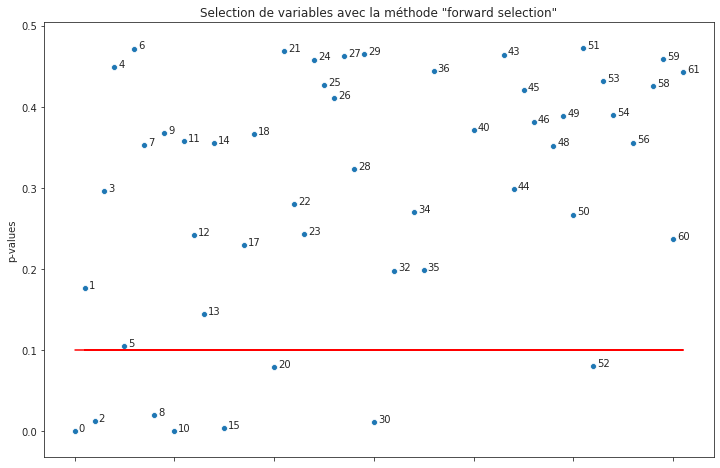

In [30]:
plt.figure(1, figsize=(12, 8))
p_values = []
for i in range(50):
    steps[i]['p_values'].sort()
    p_values.append(steps[i]['p_values'][0])

ax = sns.scatterplot(x=var_sorted[:50], y=p_values)
plt.plot(var_sorted[:50], [0.1 for i in range(len(var_sorted[:50]))], 'r')

plt.title("Selection de variables avec la méthode \"forward selection\"")
# Set y-axis label
plt.ylabel('p-values')
# Remove x-axis label
ax.set_xticklabels([])

for i in range(len(var_sorted[:50])):
    ax.text(var_sorted[i]+.4, p_values[i], str(var_sorted[i]))

In [138]:
X[20] = X_not_reduced[20]
X[52] = X_not_reduced[52]
X[32] = X_not_reduced[32]
X[35] = X_not_reduced[35]
X[15] = X_not_reduced[15]
X[23] = X_not_reduced[23]
X.drop(['SurvivalTime', 'Event'], axis=1, inplace=True)
X['SurvivalTime'], X['Event'] = data['SurvivalTime'], data['Event']
X.head()

,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,20,52,32,35,23,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,
202.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.293491,0.184211,-0.344782,0.228773,-0.538674,-0.781994,0.752173,-0.344782,-0.348309,0.729004,-0.745305,-0.473301,-0.221691,-0.404519,-0.681237,0.667254,0.729004,-0.781994,1378,0
371.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,-0.444614,-0.575949,-0.552043,0.068836,-0.407620,0.516385,0.150175,-0.552043,-0.647175,-0.436433,-0.283258,-0.309281,-0.253849,-0.352152,-0.212022,0.021530,-0.436433,0.516385,379,1
246.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,-0.288707,0.103954,-0.792104,-0.333582,-0.097071,0.604323,-0.453713,-0.792104,0.380932,-0.742136,0.683529,-0.079591,-0.204814,-0.718724,0.493356,-0.808919,-0.742136,0.604323,573,1
240.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,-0.996650,0.013334,-0.052520,-0.411829,-0.340503,0.402583,0.007286,-0.052520,-0.080325,-0.536341,-0.530241,-0.455901,-0.243214,-0.322228,-0.518171,-0.472057,-0.536341,0.402583,959,0
284.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.241589,-0.477605,-0.032319,-0.382785,0.007130,0.666397,-0.637432,-0.032319,-1.363883,-0.335268,-0.194101,-0.418225,0.525069,-0.499279,-0.149504,1.005135,-0.335268,0.666397,2119,0


In [139]:
transformer_X = ReduceVIF(thresh=6.0, index='PatientID')
X = transformer_X.fit_transform(X.reset_index())
X.head()

ReduceVIF fit
ReduceVIF transform
Dropping 10 with vif=inf
Dropping 13 with vif=inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping 17 with vif=inf
Dropping 18 with vif=14.30701991740198


,0,1,2,3,5,6,7,8,9,11,12,14,15,16,19,21,20,52,32,35,23,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,,,
202.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.293491,0.184211,0.228773,-0.538674,0.752173,-0.344782,-0.348309,-0.473301,-0.221691,-0.404519,-0.681237,0.667254,0.729004,-0.781994,1378.0,0.0
371.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,-0.444614,-0.575949,0.068836,-0.407620,0.150175,-0.552043,-0.647175,-0.309281,-0.253849,-0.352152,-0.212022,0.021530,-0.436433,0.516385,379.0,1.0
246.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,-0.288707,0.103954,-0.333582,-0.097071,-0.453713,-0.792104,0.380932,-0.079591,-0.204814,-0.718724,0.493356,-0.808919,-0.742136,0.604323,573.0,1.0
240.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,-0.996650,0.013334,-0.411829,-0.340503,0.007286,-0.052520,-0.080325,-0.455901,-0.243214,-0.322228,-0.518171,-0.472057,-0.536341,0.402583,959.0,0.0
284.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.241589,-0.477605,-0.382785,0.007130,-0.637432,-0.032319,-1.363883,-0.418225,0.525069,-0.499279,-0.149504,1.005135,-0.335268,0.666397,2119.0,0.0


#### Yet another CoxPH regression

In [140]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

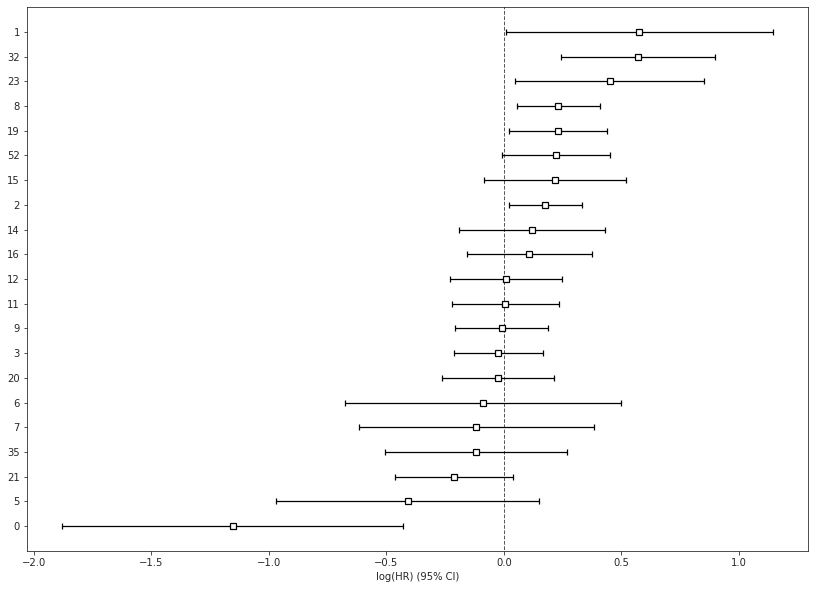

In [141]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [142]:
cph.score_

0.7278235100428054

In [111]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.7010730710270823, 0.6086253369272238, 0.6805251641137856, 0.69394261424017]
0.6710415465770654
0.03678339839362939


A little improvement by adding features with the better chance to be correlated to the target. The probleme with VIF value is that it does not take $Y$ into account. So, we could remove a feature with a lot of information to understand the distribution of $Y$.

Instead, the forward selection method try to find which feature is the must important to predict $Y$.

#### Blending method

In [36]:
import xgboost

X_xgboost, y_xgboost = X.iloc[:, :-2], X.loc[:, "SurvivalTime"]

xgb_full = xgboost.DMatrix(X_xgboost, label=y_xgboost)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [37]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_full, 6000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:4.69596
[1000]	test-cox-nloglik:4.36076
[2000]	test-cox-nloglik:4.23898
[3000]	test-cox-nloglik:4.14438
[4000]	test-cox-nloglik:4.06669
[5000]	test-cox-nloglik:3.99761
[5999]	test-cox-nloglik:3.93474


In [ ]:
xgboost_features = model_train.predict(xgb_full, output_margin=False)

In [ ]:
X.drop(['SurvivalTime', 'Event'], axis=1, inplace=True)
X['xgboost'] = xgboost_features
X['SurvivalTime'], X['Event'] = data['SurvivalTime'], data['Event']

In [144]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

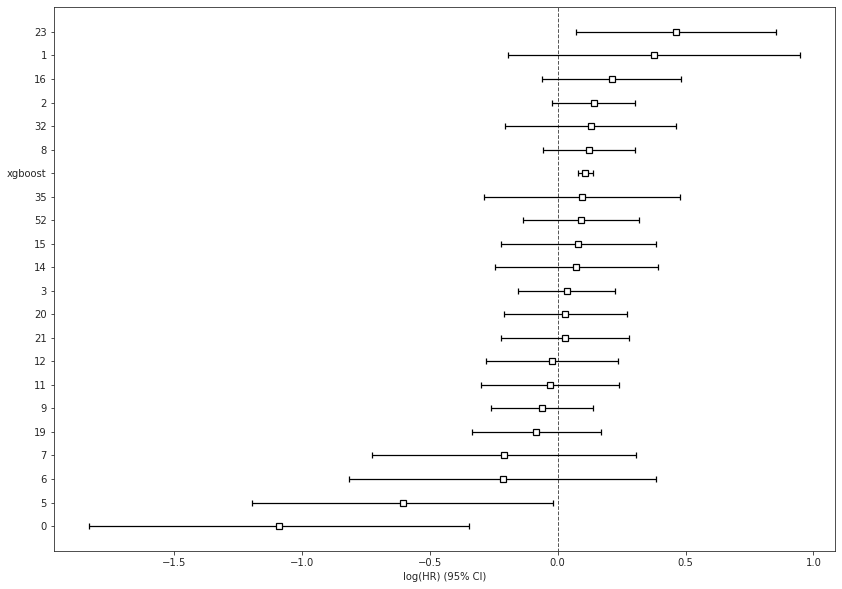

In [145]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [146]:
cph.score_

0.8211063549555483

In [43]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
print(scores)
print(np.mean(scores))
print(np.std(scores))

NameError: ignored

In [ ]:
X_test.shape

(125, 18)

In [ ]:
xgb_test = xgboost.DMatrix(X_test)
xgboost_features_test = model_train.predict(xgb_test, output_margin=False)

In [ ]:
xgboost_features_test.shape

(125,)

#### LGBM

In [359]:
import lightgbm as lgb

params = {
         'num_leaves':30, 
         'learning_rate': 0.001,
         'feature_fraction': 0.8,
         'bagging_fraction': 0.9,
         'bagging_seed': 33,
         'metric':'auc',
          'objective': 'binary',
         }

X_lgb_train, y_lgb_train = X_train.iloc[:, :-2], X_train.loc[:, "Event"]
X_lgb_test, y_lgb_test = X_test.iloc[:, :-2], X_test.loc[:, "Event"]

trn_data = lgb.Dataset(X_lgb_train, label=y_lgb_train)
val_data = lgb.Dataset(X_lgb_test, label=y_lgb_test)

model = lgb.train(params, trn_data, num_boost_round=5000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=50, early_stopping_rounds=150)

Training until validation scores don't improve for 150 rounds.
[50]	training's auc: 0.916739	valid_1's auc: 0.794872
[100]	training's auc: 0.912371	valid_1's auc: 0.798368
[150]	training's auc: 0.909713	valid_1's auc: 0.801865
Early stopping, best iteration is:
[12]	training's auc: 0.915793	valid_1's auc: 0.808275


In [ ]:
import lightgbm as lgb
feature=[c for c in X.iloc[:, :-2]]
target=X_train.loc[:, "Event"]

In [ ]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
predict = np.zeros(len(X.iloc[:, :-2]))
feature_importance_df = pd.DataFrame()

In [ ]:
param={
       'bagging_fraction': 0.33,
       'boost_from_average':'false',
       'boost': 'gbdt',
       'max_depth': -1,
       'metric':'auc',
       'objective': 'binary',
       'verbosity': 1
    }

In [260]:
from sklearn.metrics import roc_auc_score

d, y = X.iloc[:, :-2], X.loc[:, "Event"]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(d.values, y.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

    num_round = 500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 50)
    predict[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feature
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    

print("CV score: {:<8.5f}".format(roc_auc_score(target, predict)))

Fold 0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1


ValueError: ignored

#### Fast kernel survival

In [ ]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, y = X.iloc[:, :-2], X.loc[:, ['Event', 'SurvivalTime']].values

In [ ]:
dtype = [('Event', '?'), ('SurvivalTime', '<f4')]
y = [(True, time) if event==1 else (False, time) for event, time in zip(y[:,0], y[:, 1])]

In [ ]:
y = np.array(y, dtype=dtype)

In [ ]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel
from sksurv.metrics import concordance_index_censored

kernel_matrix = clinical_kernel(data_x)

In [ ]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Event'], y['SurvivalTime'], prediction)
    return result[0]

In [ ]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2),
              'degree': [2, 3, 4, 5],
              'coef0': list(np.logspace(-3, -1, 5))}
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="poly", random_state=0)
kgcv = GridSearchCV(kssvm, param_grid, score_survival_model,
                    n_jobs=4, iid=False, refit=True, cv=5)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
kgcv = kgcv.fit(data_x, y)

In [420]:
kgcv.best_score_, kgcv.best_params_

(0.6617154742359554, {'alpha': 0.000244140625, 'coef0': 0.1, 'degree': 2})

In [ ]:
data_x.shape

(294, 18)

In [ ]:
X['svm'] = kgcv.predict(X.loc[:, data_x.columns])

In [ ]:
X_test['svm_feature'] = kgcv.predict(X_test)

In [ ]:
X_test.shape

(125, 19)

In [407]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

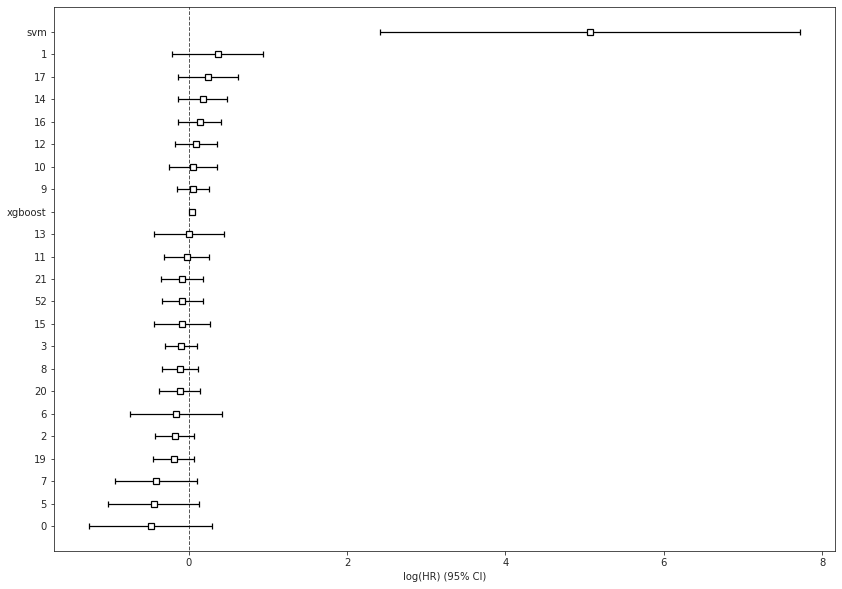

In [408]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [409]:
cph.score_

0.8311162331247942

In [411]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.7700617283950617, 0.8393595041322314, 0.8170600858369099, 0.7390078917700112]
0.7913723025335536
0.03923902971862799


#### DeepSurv

In [ ]:
data_x, y = X.iloc[:, :-2], X.loc[:, ['Event', 'SurvivalTime']].values
dtype = [('Event', '?'), ('SurvivalTime', '<f4')]
y = [(True, time) if event==1 else (False, time) for event, time in zip(y[:,0], y[:, 1])]
y = np.array(y, dtype=dtype)

In [ ]:
data_x_train, data_x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2, random_state=42)

In [46]:
from datetime import datetime

date = str(datetime.now()).replace(' ', '_')
n_alphas = np.random.randint(low=10, high=150, size=5)
alpha_min_ratio = list(np.logspace(-3, -1, 5))
l1_ratio = np.random.uniform(low=0.1, high=1, size=5)
parameters = {'n_alphas': n_alphas, 'alpha_min_ratio': alpha_min_ratio,
              'l1_ratio': l1_ratio}

date = str(datetime.now()).replace(' ', '_')
grid_coxnet = train_model_gridsearch(model=CoxnetSurvivalAnalysis(), X=data_x, y=y,
                                  parameters=parameters, cv=4,
                                  output_path=model_path / f'grid_coxnet-{date}.joblib')

Generalization score for polynomial kernel: train:0.8887984075280492, test: 0.8839009287925697
Best params:  {'alpha_min_ratio': 0.01, 'l1_ratio': 0.8454684346810784, 'n_alphas': 140}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
grid_coxnet.score(data_x_test, y_test)

0.9090143218197135

In [48]:
coxnet = CoxnetSurvivalAnalysis(**{'alpha_min_ratio': 0.1, 
                                   'l1_ratio': 0.8454684346810784, 
                                   'n_alphas': 140,
                                   'fit_baseline_model': True})
coxnet.fit(data_x, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.1, alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=0.8454684346810784,
                       max_iter=100000, n_alphas=140, normalize=False,
                       penalty_factor=None, tol=1e-07, verbose=False)

In [49]:
coxnet.score(data_x_test, y_test)

0.9090143218197135


### Submission

In [ ]:
radiomics_test, clinical_test = load_data(test_dir, target=False)
clinical_test.loc[clinical_test.Nstage == 4, 'Nstage'] = 1
clinical_test.loc[clinical_test.Tstage == 5, 'Tstage'] = 3

In [ ]:
clinical_test = clinical_test.apply(lambda row: age_fillna(row, svr_age, features_processing_reg_age), axis=1)

In [ ]:
clinical_test = clinical_test.apply(lambda row: hist_fillna(row, svc_hist,
                                                  features_processing_reg_hist), axis=1)

In [ ]:
for index, row in clinical_test.iterrows():
  if row.isna().any():
    df = clinical[(clinical['Mstage'] == row.Mstage) &
              (clinical['Nstage'] == row.Nstage) &
              (clinical['SourceDataset'] == row.SourceDataset) &
              (clinical['Tstage'] == row.Tstage)]
    row.age = df.age.median()
    row.Histology = df.Histology.value_counts().index[0]
    clinical_test.loc[index, :] = row

In [116]:
features_selection_test = radiomics_test.copy()
data_test = clinical_test.join([features_selection_test], how='left')
data.shape

(294, 21)

In [117]:
# data
binary_cat_col = ['SourceDataset', 'Mstage', 'Nstage', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data.loc[:, 'age':].columns[:-2])

data_forward_test = pd.DataFrame(processing_data_forward.transform(data_test), index=data_test.index)

data_forward_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,-2.580023,0.465119,0.373281,1.205698,-0.529622,0.488789,1.697874,-1.310172,2.388963,-0.148808,-1.299957,0.386060,0.902170,1.117075,-1.461988,0.692261,2.626921,0.213328,-1.264766,0.481436,-1.497777,1.253736,-1.205215,-0.857402,-0.907221,0.688767,-1.154893,-0.876096,0.642475,-1.490244,-1.149861,1.066282,-1.298750,1.372927,1.388250,-1.254898,0.273570,0.984004,1.229606,1.259817,1.040613,-0.609746,-1.224480,-1.716475,1.245600,2.324914,1.384686,-1.457353,-0.427073,-0.671441,-0.508732,-1.121330,-0.099096,0.191801
155,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,-0.577331,0.959442,0.953902,-1.271284,-0.832335,0.948201,-0.878938,2.230300,-0.670577,-0.489050,1.086213,-0.504433,-0.855876,-1.947448,0.434708,-1.883806,-0.671318,-0.632351,1.642766,0.960412,0.380719,-0.966706,0.205106,-1.466495,-0.284626,0.548194,0.294823,0.586033,-0.648148,0.984783,1.189231,-0.835406,1.016660,-1.461801,-1.467381,-0.301464,1.087610,-1.311638,-1.663428,-1.698186,-1.083866,-1.510255,1.101216,1.271345,-0.813696,-0.545082,-0.683913,1.310110,0.815180,-1.375602,0.972540,-1.215772,0.222068,-0.899882
404,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-0.428388,-1.614445,-1.428920,1.154495,1.718921,-1.663162,0.196827,-0.104065,-0.200475,-0.410523,-1.089176,0.650201,-0.584065,0.866112,-1.081426,0.692261,-0.934786,-0.318966,-1.002633,-1.278277,-1.014466,0.937336,-0.969022,1.458988,-0.535408,0.136589,-0.919601,-0.715690,0.285190,-0.932329,-0.894079,0.765337,-1.024704,1.019065,1.027014,-0.258621,-0.249423,0.754237,0.863803,0.957035,1.031684,1.365380,-1.029619,-0.887147,0.478911,-0.111686,-0.256756,-0.904743,-0.466542,1.480212,-0.522503,1.299792,-0.277892,0.872444
407,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.360860,0.864115,0.837382,-0.479623,-0.777808,0.860790,-0.567594,-0.303474,-0.506855,-0.467004,-0.722780,0.386339,0.046837,0.817493,-0.906645,0.671570,-0.651801,0.197198,-0.795561,-1.085264,-0.638603,0.435791,-0.724678,1.186109,-0.144228,-0.307008,-0.645798,-0.568356,0.319971,-0.637098,-0.679050,0.055698,-0.617056,0.636494,0.655041,-0.221411,0.019583,0.711085,0.787195,1.230659,0.181114,1.138068,-0.588783,-0.588503,-0.038222,-0.393061,-0.512585,-0.423282,-0.352339,1.296335,-0.386160,1.305577,-0.251776,0.225119
9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.986983,-1.321433,-1.237621,-0.210407,1.241270,-1.331948,-0.293604,0.260788,-0.452663,1.236298,0.930081,-0.387372,-0.167620,-2.991954,0.313761,-3.130457,-0.983577,0.077374,2.660686,1.648027,0.438527,-0.862350,0.269531,-2.133330,0.270242,1.988933,0.357609,1.306061,-1.513572,1.387251,1.526904,-0.841616,1.398479,-1.430055,-1.413748,2.107351,-2.203800,-1.019805,-1.247956,-1.615512,-1.084139,-2.524923,1.036963,1.167828,-0.798069,-0.460207,-0.194789,1.228105,1.749405,-1.931457,2.095516,-1.979020,0.560862,-0.965041


In [ ]:
radiomics_test = radiomics_test.loc[:, radiomics_reduced.columns]

In [119]:
data_test = clinical_test.join([radiomics_test], how='left')
data_test.shape

(125, 19)

In [120]:
data_test.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness2,original_shape_SurfaceVolumeRatio,original_firstorder_Energy,original_firstorder_Kurtosis,original_firstorder_Median,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,
13,nos,0,0,l1,4,44.3970,0.296451,0.114528,2.006942e+09,14.142104,19.0,-0.701919,21777.734066,-49.637453,2.733885,0.082816,21219.447221,0.001094,0.007535
155,adenocarcinoma,0,3,l1,1,63.3183,0.362660,0.703879,2.623938e+08,2.057162,-479.0,0.041489,229171.445706,-765.995686,49.740401,0.002095,25.291608,0.010836,0.015633
404,large cell,0,2,l1,2,64.7255,0.090945,0.315298,6.650322e+08,17.726780,19.0,-3.433133,145633.065864,-2863.528576,7.890843,0.070042,3225.808332,0.001003,0.003027
407,nos,0,0,l1,2,65.3635,0.349373,0.282104,3.754287e+08,14.145887,15.0,-3.133562,275939.432280,-5124.093237,12.627536,0.039920,1147.928170,0.001900,0.003685
9,adenocarcinoma,0,0,l2,2,50.0000,0.112759,0.376032,9.108915e+09,3.645805,-720.0,1.108723,414004.334930,6575.989794,72.888824,0.001831,652.071367,0.018221,0.024175


In [123]:
# data
binary_cat_col = ['SourceDataset', 'Mstage', 'Nstage', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data.loc[:, 'age':].columns[:-2])

X_test = pd.DataFrame(processing_data.transform(data_test), index=data_test.index)
X_test.drop([20], inplace=True, axis=1)
X_test[20] = data_forward_test[20]
X_test[52] = data_forward_test[52]
X_test[32] = data_forward_test[32]
X_test[35] = data_forward_test[35]
X_test[15] = data_forward_test[15]
X_test[23] = data_forward_test[23]
X_test.drop([4, 10, 17, 18, 13], inplace=True, axis=1)

X_test.head()

,0,1,2,3,5,6,7,8,9,11,12,14,15,16,19,21,20,52,32,35,23
PatientID,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,3.0,0.0,1.0,0.0,-2.580023,0.373281,-0.148808,0.386060,0.481436,-1.310172,0.688767,2.324914,-0.099096,0.902170,1.245600,-0.907221,-0.876096,0.692261
155,0.0,0.0,3.0,0.0,0.0,0.0,0.0,-0.577331,0.953902,-0.489050,-0.504433,0.960412,2.230300,0.548194,-0.545082,0.222068,-0.855876,-0.813696,-0.284626,0.586033,-1.883806
404,0.0,0.0,2.0,1.0,1.0,0.0,0.0,-0.428388,-1.428920,-0.410523,0.650201,-1.278277,-0.104065,0.136589,-0.111686,-0.277892,-0.584065,0.478911,-0.535408,-0.715690,0.692261
407,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.360860,0.837382,-0.467004,0.386339,-1.085264,-0.303474,-0.307008,-0.393061,-0.251776,0.046837,-0.038222,-0.144228,-0.568356,0.671570
9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.986983,-1.237621,1.236298,-0.387372,1.648027,0.260788,1.988933,-0.460207,0.560862,-0.167620,-0.798069,0.270242,1.306061,-3.130457


In [ ]:
X_test['xgboost'] = xgboost_features_test

In [128]:
X_test.head()

,0,1,2,3,5,6,7,8,9,11,12,14,15,16,19,21,20,52,32,35,23,xgboost
PatientID,,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,3.0,0.0,1.0,0.0,-2.580023,0.373281,-0.148808,0.386060,0.481436,-1.310172,0.688767,2.324914,-0.099096,0.902170,1.245600,-0.907221,-0.876096,0.692261,8.238535
155,0.0,0.0,3.0,0.0,0.0,0.0,0.0,-0.577331,0.953902,-0.489050,-0.504433,0.960412,2.230300,0.548194,-0.545082,0.222068,-0.855876,-0.813696,-0.284626,0.586033,-1.883806,3.842910
404,0.0,0.0,2.0,1.0,1.0,0.0,0.0,-0.428388,-1.428920,-0.410523,0.650201,-1.278277,-0.104065,0.136589,-0.111686,-0.277892,-0.584065,0.478911,-0.535408,-0.715690,0.692261,5.140564
407,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.360860,0.837382,-0.467004,0.386339,-1.085264,-0.303474,-0.307008,-0.393061,-0.251776,0.046837,-0.038222,-0.144228,-0.568356,0.671570,3.185928
9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.986983,-1.237621,1.236298,-0.387372,1.648027,0.260788,1.988933,-0.460207,0.560862,-0.167620,-0.798069,0.270242,1.306061,-3.130457,0.695435


In [ ]:
from scipy.integrate import trapz

patients = X_test.index
v = coxnet.predict_survival_function(X_test)
survival_df = pd.DataFrame(index=v[0].x)

for ind, patient in enumerate(patients):
  survival_df[patient] = v[ind].y

predictions = pd.DataFrame(trapz(survival_df.values.T, survival_df.index), index=patients)

In [ ]:
predictions = cph.predict_expectation(X_test)

In [148]:
predictions.head()

,0
13,822.079940
155,1148.371228
404,933.908732
407,1180.839987
9,2965.831283


In [ ]:
predictions.reset_index(inplace=True)
predictions.rename(columns={18: 'PatientID', 0: 'SurvivalTime'}, inplace=True)
predictions['Event'] = 'nan'

In [ ]:
date = str(datetime.now()).replace(' ', '_')
predictions.to_csv(data_path / f"submission_{date}.csv", index=False)